![Banner](img/banner.png)

# **Taller:**  Descomposición de Valores Singulares (SVD) y Análisis de Componentes Principales (PCA)

***Matemáticas para Machine Learning***

**Semana 2 - Práctica Calificada -** Matrices simétricas positivas definidas

**Profesor:** *Fernando Lozano* - **Autor Notebook:** *César Garrido Urbano*


# Introducción

## Descripción


El presente *jupyter notebook* contiene todo el material para el desarrollo del Taller de la Semana 2 del curso ***Matématicas para Machine Learning***. En este se pondrán en práctica algunas de las aplicaciones más conocidas de la descomposición en valores singulares o *Singular Value Decomposition* (SVD) y algunos de los temas de algebra lineal relacionados con el curso.

**Objetivos de Aprendizaje:**

* Determinar e interpretar el concepto de matriz positiva (semi) definida, negativa (semi) definida o indefinida. 
* Interpretar los componentes de la descomposición en valores singulares de una matriz.
* Estudiar e implementar las distintas aplicaciones que tiene la técnica de SVD en contextos prácticos como:
  * Compresión de imagenes
  * Reducción de dimensionalidad
  * Clasificación de caracteristicas principales


## Metodología

En la primera mitad del cuaderno usted encontrará varias implementaciones sencillas de SVD con algunos ejemplos prácticos. En esta sección usted podrá experimentar con dichos ejemplos, deberá responder algunas preguntas a partir de los resultados y/o completar algunas funciones para la visualización de los datos. 

En la segunda parte del cuaderno pondrá en práctica lo estudiado y repasado en la primera mitad para un problema en específico. En este caso trabajando con un subconjunto de datos del bien conocido y estudiado dataset de [Perros vs Gatos](https://www.kaggle.com/competitions/dogs-vs-cats/data).

Para desarrollar el taller usted deberá editar las celdas de código dispuestas para esto. Estas estarán marcadas con el siguiente comentario:

```python
# =====================================================
# COMPLETAR ===========================================
# 

# =====================================================
```

Edite o complete el códgio dentro de estas lineas de comentarios. Sin embargo, no se límite únicamente a estas celdas y siéntase libre de editar las celdas de ejemplo o de explicación para familiarizarse con el código, el problema y/o responder ciertas preguntas.

Adicionalmente, se encontrará con preguntas a las que deberá responder a partir del trabajo que realice durante el Taller. Utilice las celdas de Markdown dispuestas para esto, estas estarán marcadas de la siguiente manera:

**Respuesta:**

## Teoría


### Rango de una matriz

Recuerde que el rango de una matriz esta dado por el número de de filas (o columnas) linealmente independientes dentro de una matriz. Es decir filas que no se puedan expresar como una combinación lineal de otras filas:

\begin{equation}
r_3 \neq a r_1 + b r_2 
\end{equation}

En este caso $r_3$ es linealmente independiente de $r_1$ y $r_2$. De forma intuitiva, este valor esta asociado a la cantidad de información unica que nos brinda esta matriz, a mayor número de filas independientes, mayor la información única que nos da cada fila.

### SVD

Esto es importante pues el objetivo de la descomposición de valores singulares (SVD) es la respresentación de una matriz $A$ como el producto de 3 matrices de la siguiente manera:

\begin{equation}
A_{m\times n} = U_{m\times m}S_{m\times n}V_{n\times n}^T = \begin{bmatrix}
            u_1 & ... & u_n
            \end{bmatrix}
            \begin{bmatrix}
            \sigma_1 &  & 0 \\
              & \ddots &  \\
             0 &  & \sigma_n
            \end{bmatrix}
            \begin{bmatrix}
            v_1^T \\ \vdots \\ v_n^T
            \end{bmatrix} = \sum_{i=1}^n \sigma_i u_i v_i^T
\end{equation}

Donde: 

*   $A$ es la matriz original
*   $U$ es una matriz mxm de vectores singulares izquierdos ($u_i$)
*   $S$ es una matriz diagonal con los valores singulares ($\sigma_i$)
*   $V$ es una matriz nxn con los vectores singulares derechos ($v_i$)



Esta descomposición, en últimas, nos permite respresentar nuestra matriz original ($A$) como una combinación lineal de matrices ($\sigma_i u_i v_i^T$) de rango 1!

Adicionalmente, es posible truncar dicha suma en un número $k$ inferior de matrices sin perder mucha información:





![TruncatedSVD.png](img/TruncatedSVD.png)

# 1. Implementación SVD


## Importar Datos

In [1]:
# Librerias principales
import os
import cv2
import zipfile
import numpy as np
import pandas as pd

# Sklearn
from sklearn.datasets import load_digits, load_sample_images
from sklearn.decomposition import TruncatedSVD, PCA

# Tensorflow
import tensorflow as tf

# Visualización
import plotly.express as px
import matplotlib.pyplot as plt 

from IPython.display import display, HTML

In [2]:
# Dataset de números escritos a mano
(X_digitos, y_digitos), (_, _) = tf.keras.datasets.mnist.load_data()

# Normalizar imagenes entre [-1, 1]
X_digitos = (X_digitos - 127.5) / 127.5

# Tomar solo los primeros 1000 datos
X_digitos = X_digitos[0:1000]
y_digitos = y_digitos[0:1000]

In [3]:
# Dataset de imagenes de ejemplo
dataset_img = load_sample_images()

## Imagenes Comprimidas

En esencia, las imagenes no son más que matrices donde cada número denota la intensidad de cada píxel. Tome como ejemplo la siguiente imagen cargada desde la librería de $\texttt{sci-kit learn}$.

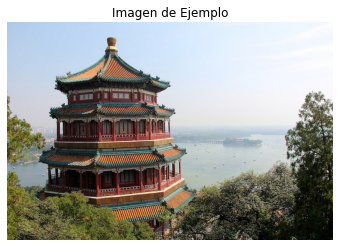

In [4]:
# Visualizar imagen de ejemplo
img_ejemplo = dataset_img.images[0] 
plt.imshow(img_ejemplo)
plt.axis('off')
plt.title('Imagen de Ejemplo')
plt.show()

Inspecione las dimensiones y los valores de la imagen.

In [5]:
img_ejemplo.shape

(427, 640, 3)

In [6]:
img_ejemplo

array([[[174, 201, 231],
        [174, 201, 231],
        [174, 201, 231],
        ...,
        [250, 251, 255],
        [250, 251, 255],
        [250, 251, 255]],

       [[172, 199, 229],
        [173, 200, 230],
        [173, 200, 230],
        ...,
        [251, 252, 255],
        [251, 252, 255],
        [251, 252, 255]],

       [[174, 201, 231],
        [174, 201, 231],
        [174, 201, 231],
        ...,
        [252, 253, 255],
        [252, 253, 255],
        [252, 253, 255]],

       ...,

       [[ 88,  80,   7],
        [147, 138,  69],
        [122, 116,  38],
        ...,
        [ 39,  42,  33],
        [  8,  14,   2],
        [  6,  12,   0]],

       [[122, 112,  41],
        [129, 120,  53],
        [118, 112,  36],
        ...,
        [  9,  12,   3],
        [  9,  15,   3],
        [ 16,  24,   9]],

       [[116, 103,  35],
        [104,  93,  31],
        [108, 102,  28],
        ...,
        [ 43,  49,  39],
        [ 13,  21,   6],
        [ 15,  24,   7]]

Note que esta imagen esta compuesta por tres matrices de 427x640. Cada matriz esta asociada a la intensidad de tres colores: rojo, azul y verde (o RGB, por sus siglas en inglés), las cuales logran componer una imagen a color.

Dado que se desea trabajar con una única matriz, se hace la conversión a blanco y negro con la siguiente función:

In [7]:
def convertir_blanco_y_negro(img):
    # Verificar tipo
    if type(img) != np.ndarray:
        img = np.array(img)
    
    # Verificar dimensiones (Imagen a color)
    assert img.shape[2] == 3, "Las dimensiones de la imagen no coinciden! Debe tener las tres dimensiones de color RGB"

    # Se convierte la imagen a blanco y negro (Se pasa de 3 matrices a 1 matriz)
    img_bn = 0.2125*img[:, :, 0] + 0.7154*img[:, :, 1] + 0.0721*img[:, :, 2]

    return img_bn

In [8]:
# Se convierte la imagen a blanco y negro (Se pasa de 3 matrices a 1 matriz)
img_bn = convertir_blanco_y_negro(img_ejemplo)

Inspecione las nuevas dimensiones

In [9]:
img_bn.shape

(427, 640)

Ahora, con esta unica matriz procedemos a realizar la descomposicón por vectores singulares utilizando la librería de $\texttt{numpy}$.

In [10]:
# Se realiza la descomposicion SVD
U, S, V = np.linalg.svd(img_bn)

Inspecciones las dimensiones y los valores de las matrices $U, S, V^T$.

In [11]:
# Edite para imprimir valores o dimensiones
print(U.shape)
print(S)
print(V.shape)

(427, 427)
[8.34457304e+04 1.55621738e+04 9.75696183e+03 5.78968973e+03
 4.71569088e+03 4.20095221e+03 3.94403417e+03 3.41884420e+03
 3.12641252e+03 3.05165937e+03 2.95435812e+03 2.72468358e+03
 2.64654073e+03 2.42621572e+03 2.29981935e+03 2.18362104e+03
 2.11828970e+03 2.05182201e+03 1.99575605e+03 1.95305164e+03
 1.89585507e+03 1.88181665e+03 1.83077188e+03 1.80953176e+03
 1.74851226e+03 1.68882983e+03 1.66335699e+03 1.63547272e+03
 1.56815642e+03 1.56346964e+03 1.51382021e+03 1.48947831e+03
 1.45504585e+03 1.43581627e+03 1.40474227e+03 1.37095571e+03
 1.34641771e+03 1.32331209e+03 1.30611104e+03 1.30296689e+03
 1.28464951e+03 1.24449727e+03 1.23004662e+03 1.21882183e+03
 1.21268628e+03 1.20596997e+03 1.19144015e+03 1.16598613e+03
 1.14559592e+03 1.12748814e+03 1.11636540e+03 1.10007360e+03
 1.09459548e+03 1.07619183e+03 1.05953040e+03 1.05458180e+03
 1.05046373e+03 1.02892872e+03 1.02055846e+03 1.00069752e+03
 9.90286998e+02 9.74562139e+02 9.71167435e+02 9.69513270e+02
 9.53611559e+

Finalmente, se reconstruyen estas imagenes solo con un número determinado de componentes.

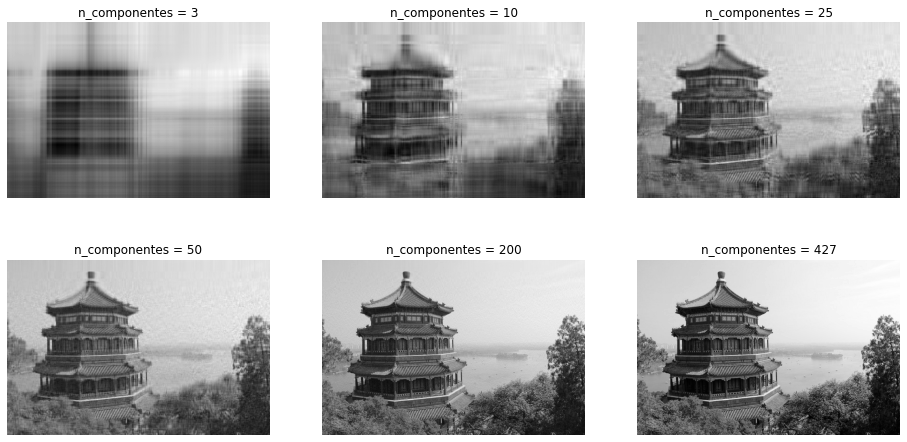

In [12]:
# Numero de componentes de prueba
n_componentes = [3, 10, 25, 50, 200, 427]

# Figura de las diferentes imagenes
plt.figure(figsize = (16, 8))

for i, n in enumerate(n_componentes):
    # Reconstruccion de imagen con solo n componentes
    img_reducida = U[:, :n] @ np.diag(S[:n]) @ V[:n, :]
    # Gráfica
    plt.subplot(2, 3, i+1)
    plt.imshow(img_reducida, cmap = 'gray')
    plt.title(f'n_componentes = {n}')
    plt.axis('off')


Piense ¿Cuantas componentes son realmente necesarias para reconstruir la imagen?

Varie el número de componentes en el vector $\texttt{n componentes}$ para explorar distintos niveles de compresión de la imagen.

Ahora bien, para visualizar de mejor manera la información que aportan cada uno de los componentes a la reconstrucción de la imagen se puede graficar el aporte de cada componente ($S$) con la clase $\texttt{TruncatedSVD}$ de la librería de $\texttt{sci-kit learn}$.

In [13]:
def graficar_valor_componentes(img):
    """
    Gráfica el aporte acumulado de cada componente dada una imagen en blanco y negro.
    ___________________________________
    Entrada:
    img:        [numpy.ndarray] Matriz de una imagen en blanco y negro
    ___________________________________
    Salida:
    fig         [plt.fig] Figura con gráfico
    """
    fig = plt.figure(figsize=(8, 5))
    
    # Varianza Truncated SVD
    svd = TruncatedSVD(n_components=426).fit(img_bn)
    var_svd = np.cumsum(svd.explained_variance_ratio_)

    # Grafica
    plt.plot(var_svd)
    plt.grid('on')
    
    # Títulos
    plt.xlabel('Número de Componentes')
    plt.ylabel('Varianza acumulada (%)')
    plt.title('Aporte porcentual acumulado por cada componenete')

    return fig

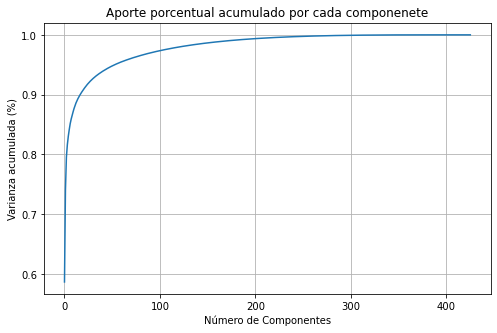

In [14]:
# Probar función
graficar_valor_componentes(img_bn)
plt.show()

¿Coincide esta gráfica con las imagenes que se obtienen para cada número de componentes? Responda ahora sí ¿Cuantas componentes cree que son necesarias ara reconstruir la imagen?

**Respuesta:**

> La coincidencia se hace evidente al observar que cuando se emplea un número de componentes inferior a 50, las imágenes resultantes tienden a mostrar distorsiones notables. Este fenómeno se debe a que la suma acumulada de las varianzas explicadas por estos componentes no alcanza a superar el umbral del 80%. En consecuencia, la transformación de las imágenes utilizando solo estos primeros componentes no abarca la totalidad de la información necesaria para una representación adecuada de los datos. Es decir, no logra capturar de manera precisa las características esenciales de las imágenes, lo que resulta en una pérdida significativa de detalle y fidelidad en la representación visual de los datos.

> El número de componentes necesarias para reconstruir la imagen, sin tener información redundante, es aquel que la suma acumulada de las varianzas supere el 90%. En este caso podemos ver que entre 85 y 100 componentes se alcanza una suma acumulada de varianzas de más del 90%. Por lo que con esta descomposición tenemos una buena representación de la información. 

## Reducción de dimensionalidad

Considere este otro ejemplo del conocido dataset $\texttt{MNIST}$, el cual contiene imagenes (ya en blanco y negro) de digitos del 0 al 9 escritos a mano.

Inspecione las dimensiones y los valores de la imagen.

In [15]:
# Imagen de ejemplo
digit_sample_img = X_digitos[0]
digit_sample_img = digit_sample_img.reshape((28, 28))

# Imprimir tamaño de la imagen
print(digit_sample_img.shape)

(28, 28)


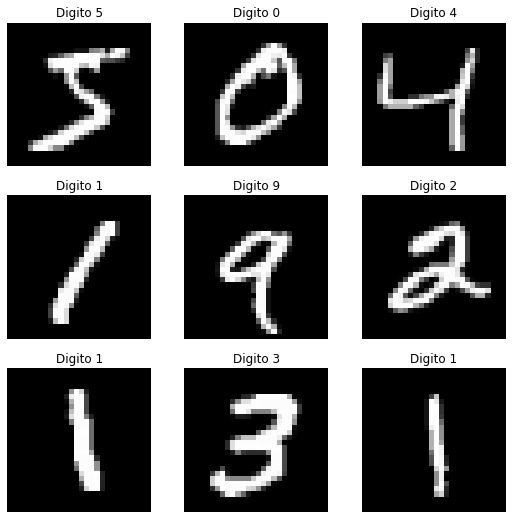

In [16]:
# Visualizacion de las primeras 9 imagenes del dataset
fig = plt.figure(figsize=(9, 9))

# Plot
for i in range(0,9):
    plt.subplot(3, 3, i+1)
    plt.imshow(X_digitos[i].reshape((28, 28)), cmap = 'gray')
    plt.title(f'Digito {y_digitos[i]}')
    plt.axis('off')

plt.show()

Ahora se desea descomponer estas imagenes en tan solo 3 componentes para visualizar la posición de estos digitos en otro espacio (de tan solo 3 dimensiones!).

Para esto realizamos la descomposición con la clase $\texttt{TruncatedSVD}$ de la librería de $\texttt{sci-kit learn}$.

In [17]:
# Descomposición en 3 dimensiones con Truncated SVD
svd = TruncatedSVD(n_components=3)
X_digits_transformed = svd.fit_transform(X_digitos.reshape(1000,28*28))

# Conversión a DF para su visualización
df = pd.DataFrame(X_digits_transformed)
df.columns = ['Componente 1', 'Componente 2', 'Componente 3']
df['Digito'] = y_digitos

# Visualización de datos
df.head(10)

Componente 1  Componente 2  Componente 3  Digito
0     22.821824      1.740867      2.894201       5
1     21.899780      8.726873      4.256225       0
2     22.173674      0.252366     -3.369010       4
3     24.181906     -8.095578      4.507213       1
4     23.705567     -1.826351     -5.286789       9
5     22.770595      1.903119     -0.453988       2
6     24.246956     -4.511485     -0.495189       1
7     22.143249      3.828340      5.020755       3
8     24.953401     -5.196355     -1.267108       1
9     23.641231      0.207391     -3.378399       4

In [18]:
# Selección solo de los primeros 4 digitos (0, 1, 2, 3)
filtro = df['Digito'] < 4
df_filtrado = df[filtro]

# Plot (Gráfica en 3D)
fig = px.scatter_3d(df_filtrado, x='Componente 1', y='Componente 2', z='Componente 3', color='Digito')
fig.update_traces(marker=dict(size=6, line=dict(width=1, color='DarkSlateGrey')), selector=dict(mode='markers'))
fig.show()

Ahora bien, la clase $\texttt{TruncatedSVD}$ solo implementa parte del algoritmo PCA (Principal Component Analysis) que ya fue implementado en previos laboratorios. Por suerte, la librería de $\texttt{sci-kit learn}$ también provee esta clase!

In [19]:
# Descomposición en 3 dimensiones con PCA
pca = PCA(n_components=3)
X_digits_transformed = pca.fit_transform(X_digitos.reshape(1000,28*28))

# Conversión a DF para su visualización
df = pd.DataFrame(X_digits_transformed)
df.columns = ['Componente 1', 'Componente 2', 'Componente 3']
df['Digito'] = y_digitos

# Selección solo de los primeros 4 digitos (0, 1, 2, 3)
filtro = df['Digito'] < 4
df_filtrado = df[filtro]

# Plot (Gráfica en 3D)
fig = px.scatter_3d(df_filtrado, x='Componente 1', y='Componente 2', z='Componente 3', color='Digito')
fig.update_traces(marker=dict(size=6, line=dict(width=1, color='DarkSlateGrey')), selector=dict(mode='markers'))
fig.show()

¿Nota alguna relación entre la posición de los digitos en el nuevo espacio 3D y la forma de los mismos?

Pruebe con distintas combinaciones de digitos, la implementación de SVD y PCA y escriba sus conclusiones a continuación.

**Respuesta:**
> Es evidente que existe una agrupación más densa en el caso de los dígitos '1'. Incluso cuando se varía la cantidad de dígitos incluidos en la agrupación, se observa que el dígito '1' presenta una menor variabilidad en sus características. Esto se traduce en que, en un espacio de tres componentes, las características de los dígitos '1' son notablemente más similares entre sí en comparación con otros dígitos


# 2. Ejercicio Práctico

## Importar Datos

In [20]:
def cargar_imagenes(carpeta, dim=(64,64), byn = True):
    """
    Cargar imagenes de la carpeta por parametro.
    ___________________________________
    Entrada:
    carpeta:        [numpy.ndarray] Matriz de una imagen en blanco y negro.
    dim:            [tuple] Dimensiones a las que se quiere estandarizar las imagenes.
    byn:            [boolean] Si se desea o no convertir las imagenes a blanco y negro.
    ___________________________________
    Salida:
    imagenes        [list(numpy.ndarray)] Arreglo de imagenes.
    """
    imagenes = []
    # Recorrer todos los archivos en la carpeta
    for archivo in os.listdir(carpeta):  
        # Verificar formato
        if archivo.endswith('.jpg'):
            # Cargar Imagen
            img = cv2.imread(os.path.join(carpeta, archivo))
            if img is None:
                pass
            # Corregir Color
            im_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # Ajustar a un único tamaño
            if dim is not None:
                img_ajustada = cv2.resize(im_rgb, dim, interpolation = cv2.INTER_AREA)
            # Convertir a blanco y negtro
            if byn:
                img_ajustada = convertir_blanco_y_negro(img_ajustada)
            # Agregar
            imagenes.append(img_ajustada)

    return np.array(imagenes)

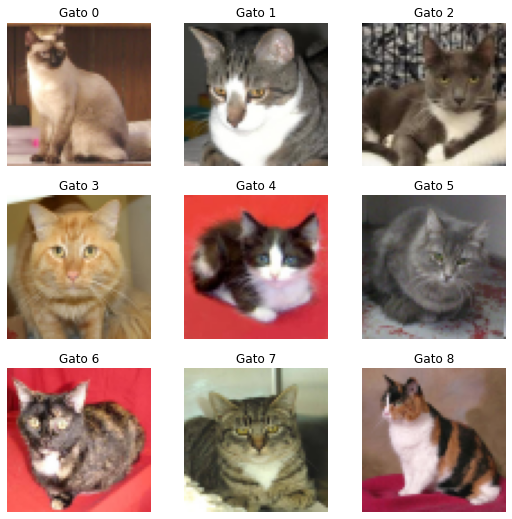

In [21]:
# Cargar imagenes de Gatos a color
img_gatos = cargar_imagenes("img/Gatos", byn = False)

# Visualizacion de las primeras 9 imagenes del dataset de Gatos
fig = plt.figure(figsize=(9, 9))

# Plot
for i, example in enumerate(img_gatos):
    plt.subplot(3, 3, i+1)
    plt.imshow(example, cmap = 'gray')
    plt.title(f"Gato {i}")
    plt.axis('off')
    if i >= 8:
        break

plt.show()

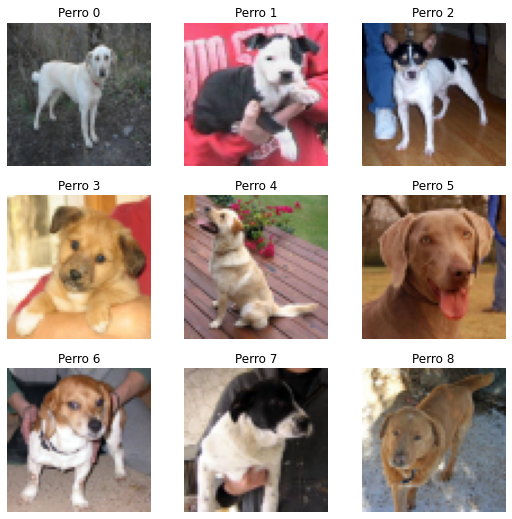

In [22]:
# Cargar imagenes de Perros a color
img_perros = cargar_imagenes("img/Perros", byn = False)

# Visualizacion de las primeras 9 imagenes del dataset de Gatos
fig = plt.figure(figsize=(9, 9))

# Plot
for i, example in enumerate(img_perros):
    plt.subplot(3, 3, i+1)
    plt.imshow(example, cmap = 'gray')
    plt.title(f"Perro {i}")
    plt.axis('off')
    if i >= 8:
        break

plt.show()

## Compresión de Imagenes

Seleccione una imagen del subconjunto de perros y otro del de gatos y comprímala para un distinto número de componentes tal y como se hizo para la imagen de ejemplo. ¿Cuantas componentes son necesarias para reconstruir la imagen del perro y del gato? ¿Esto varía dependiendo del animal? ¿De la foto?

### Se hace uso de la función graficar_valor_componentes para la grafica de las imagenes

In [23]:
def graficar_valor_componentes_2(img, n_components):
    fig = plt.figure(figsize=(8, 5))
    # Varianza Truncated SVD
    svd = TruncatedSVD(n_components=n_components).fit(img_bn)
    var_svd = np.cumsum(svd.explained_variance_ratio_)
    # Grafica
    plt.plot(var_svd)
    plt.grid('on')
    # Títulos
    plt.xlabel('Número de Componentes')
    plt.ylabel('Varianza acumulada (%)')
    plt.title('Aporte porcentual acumulado por cada componenete')
    return fig

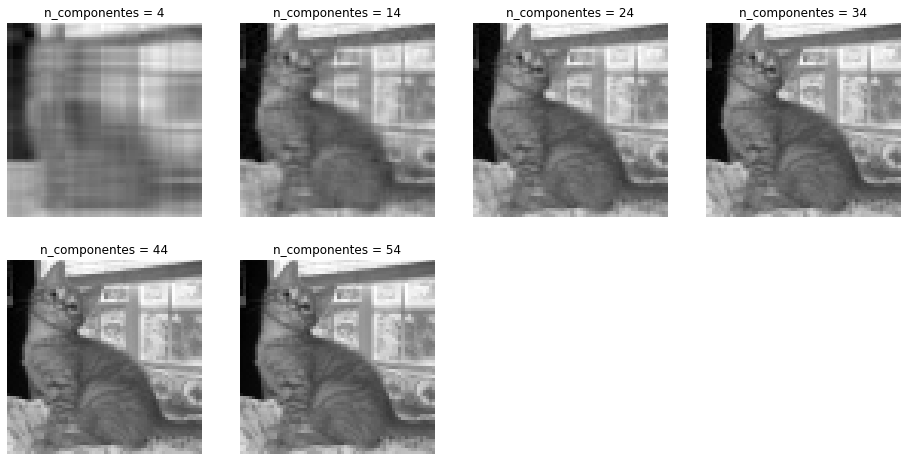

In [24]:
# =====================================================
# COMPLETAR ===========================================
# 
# Compersión imagen de gato
cat_i = 19
img_cat = img_gatos[cat_i]
img_cat_tr = convertir_blanco_y_negro(img_cat)
U, S, V = np.linalg.svd(img_cat_tr)

n_comp = [i for i in range(4, img_cat_tr.shape[0], 10)]
# Figura de las diferentes imagenes

plt.figure(figsize = (16, 8))
for i, n in enumerate(n_comp):
    img_reducida = U[:, :n] @ np.diag(S[:n]) @ V[:n, :]
    plt.subplot(2, 4, i+1)
    plt.imshow(img_reducida, cmap = 'gray')
    plt.title(f'n_componentes = {n}')
    plt.axis('off')

# =====================================================

### Grafica de comporación N-componentes vs %Varianza acumulada

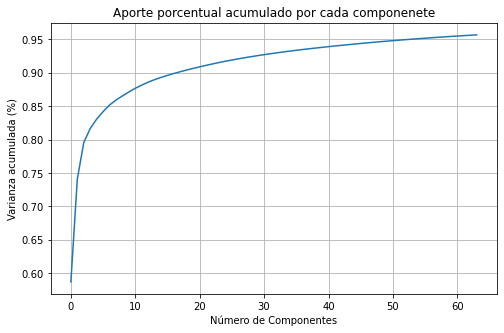

In [25]:
graficar_valor_componentes_2(img_cat_tr, n_components=img_cat_tr.shape[0])
plt.show()

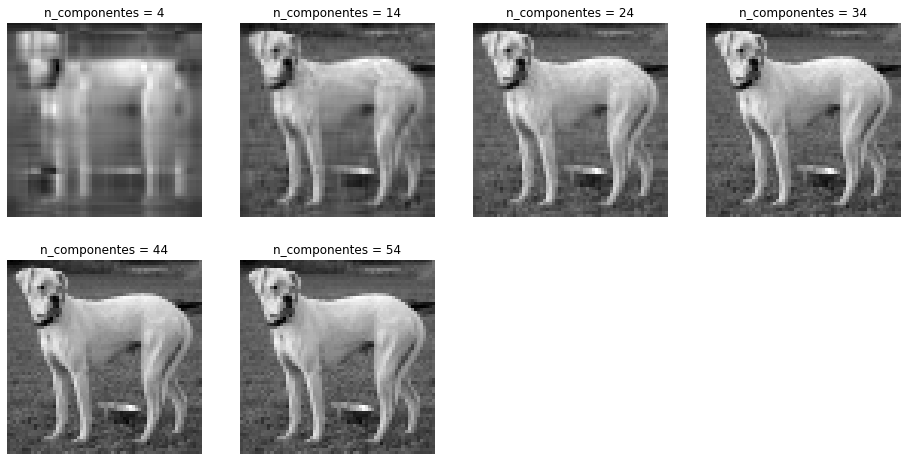

In [26]:
# =====================================================
# COMPLETAR ===========================================
# 
# Compersión imagen de gato
dog_i = 19
img_dog = img_perros[dog_i]
img_dog_tr = convertir_blanco_y_negro(img_dog)
U, S, V = np.linalg.svd(img_dog_tr)

n_comp = [i for i in range(4, img_dog_tr.shape[0], 10)]
# Figura de las diferentes imagenes

plt.figure(figsize = (16, 8))
for i, n in enumerate(n_comp):
    img_reducida = U[:, :n] @ np.diag(S[:n]) @ V[:n, :]
    plt.subplot(2, 4, i+1)
    plt.imshow(img_reducida, cmap = 'gray')
    plt.title(f'n_componentes = {n}')
    plt.axis('off')

# =====================================================


### Grafica de comporación N-componentes vs %Varianza acumulada

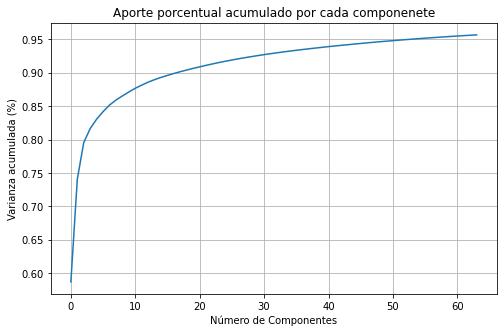

In [27]:
graficar_valor_componentes_2(img_dog_tr, n_components=img_dog_tr.shape[0])
plt.show()

**Respuesta:**

> Se puede evidenciar que en ejercicio de la eleccion de la imagen del gato la cantidad de componentes necesarios para la visibilidad de la imagen es de 15 componentes debido a que en la grafica de N_componentes vs varianza se evidencia que con 15 compnentes ya se tiene mas del 90% de la varianza.

> En el caso del perro se puede evidenciar que la cantidad de componentes necesarios para la visibilidad de la imagen es de 15 componentes debido a que en la grafica de N_componentes vs varianza se evidencia que con 15 compnentes ya se tiene mas del 90% de la varianza acomulada

## Reducción de dimensionalidad

Descomponga todas las imagenes de los perros y los gatos y reduzcalos a tan solo 3 componentes. Visualice la ubicación de las imagenes en el nuevo espacio. ¿Tienen sentido? ¿Por qué sí o por qué no?

In [28]:
# =====================================================
# COMPLETAR ===========================================
# 

# Reducción de dimensionalidad
# Descomposición en 3 dimensiones con Truncated SVD

data_list = []
label_list = []

for i in range(img_gatos.shape[0]):
    x = convertir_blanco_y_negro(img_gatos[i])
    data_list.append(x.reshape(64*64))
    label_list.append('Gato')
    
for i in range(img_perros.shape[0]):
    x = convertir_blanco_y_negro(img_perros[i])
    data_list.append(x.reshape(64*64))
    label_list.append('Perro')
    
data_array = np.array(data_list)
print()
svd = TruncatedSVD(n_components=3)
array_transf = svd.fit_transform(data_array)

# Conversión a DF para su visualización
df = pd.DataFrame(array_transf)
df.columns = ['Componente 1', 'Componente 2', 'Componente 3']
df['Class_Animal'] = label_list

# Visualización de datos
df.head(10)

Componente 1  Componente 2  Componente 3 Class_Animal
0   7464.281244  -1329.512223  -1161.441285         Gato
1   8003.680193  -3020.433127  -1235.864513         Gato
2   6432.692296   -301.614831   -771.603614         Gato
3   8533.100127   -445.566203   1091.446146         Gato
4   6383.270101    167.415103    359.066231         Gato
5   5961.695608   -241.202193    366.907578         Gato
6   7266.390502   -654.697107   -116.967094         Gato
7   8283.784016   1186.697244     15.341140         Gato
8   6989.787683   -204.231630    -26.305510         Gato
9   9928.489512   2908.097581    757.590443         Gato

In [29]:
# =====================================================
# COMPLETAR ===========================================
# Visualización
fig = px.scatter_3d(df, x='Componente 1', y='Componente 2', z='Componente 3', color='Class_Animal')
fig.update_traces(marker=dict(size=6, line=dict(width=1, color='DarkSlateGrey')), selector=dict(mode='markers'))
fig.show()
# =====================================================

**Respuesta:**
> Al llevar a cabo la descomposición de las imágenes de perros y gatos, no se observa una agrupación distintiva de individuos. Esto podría deberse a que las características físicas comunes a ambos, como las dos orejas, dos ojos, un hocico y cuatro patas, pueden dificultar su diferenciación en un análisis de características reducidas. Una estrategia para mejorar este problema consiste en la adquisición de más datos y su representación en un espacio visual más amplio.

## Proyección de los datos en un nuevo espacio

Por último, transforme las imagenes de perros y gatos por separado y proyecte algun ejemplo de su gusto en el espacio contrario. Es decir, tome una foto de un gato y proyectela en el espacio proyectado de los perros y viceversa. Gráfique la imagen resultante ¿Qué nota de interesante en estas nuevas imagenes?

Hint: Considere la función $\texttt{inverse_transform}$ de las clases $\texttt{PCA}$ y $\texttt{TruncatedSVD}$.

In [30]:
# =====================================================
# COMPLETAR ===========================================
data_list_cats = []
data_list_dogs = []

#================= Espacio del GATO =======================================
for i in range(img_gatos.shape[0]):
    x = convertir_blanco_y_negro(img_gatos[i])
    data_list_cats.append(x.reshape(64*64))
    
data_array_cats = np.array(data_list_cats)  
svd_cats = TruncatedSVD(n_components=300)
space_cats= PCA(n_components = 30)
space_cats.fit(data_array_cats)

#================= Espacio del PERRO =======================================
for i in range(img_perros.shape[0]):
    x = convertir_blanco_y_negro(img_perros[i])
    data_list_dogs.append(x.reshape(64*64))

data_array_dogs = np.array(data_list_dogs)  
svd_dogs = TruncatedSVD(n_components=4000)
space_dogs= PCA(n_components = 30)
space_dogs.fit_transform(data_array_dogs);

Text(0.5, 1.0, 'Gato-Perro')

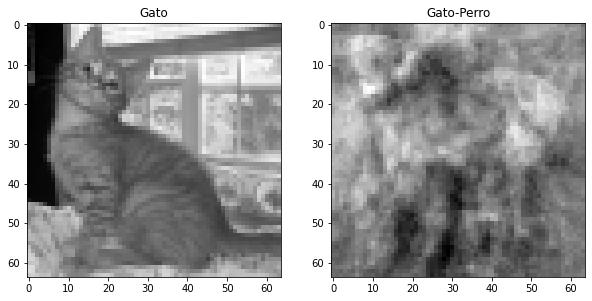

In [31]:
# Proyección de GATO en el espacio de perro
### Ejemplo de un gato 
cat_eje = img_cat_tr
#plt.imshow(gato_ejemplo, cmap = 'gray')
plt.show()
cat_eje_reshape = cat_eje.reshape(1,64*64)
cat_eje_trans = space_cats.transform(cat_eje_reshape)
#print(gato_ejemplo_trans)

#Transformar el gato a al espacio del perror 
cat_dog = space_dogs.inverse_transform(cat_eje_trans)
cat_dog_img = cat_dog.reshape(64,64)
#plt.imshow(gato_perro_img, cmap = 'gray')
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cat_eje, cmap = 'gray')
plt.title('Gato')
plt.subplot(1, 2, 2)
plt.imshow(cat_dog_img, cmap = 'gray')
plt.title('Gato-Perro')
# =====================================================

Text(0.5, 1.0, 'Perro-Gato')

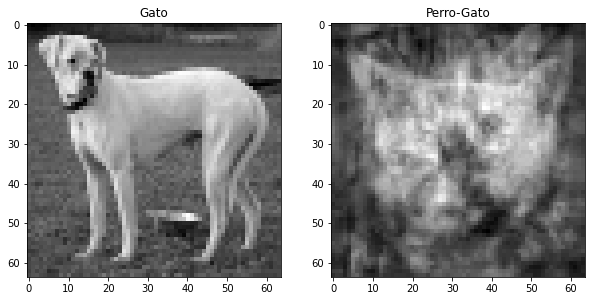

In [32]:
# Proyección de PERRO en el espacio del gato
### Ejemplo de un gato 
dog_eje = img_dog_tr
dog_eje_reshape = dog_eje.reshape(1,64*64)
dog_eje_trans = space_cats.transform(dog_eje_reshape)

#Transformar el gato a al espacio del perror 
dog_cat = space_cats.inverse_transform(dog_eje_trans)
dog_cat_img = dog_cat.reshape(64,64)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(dog_eje, cmap = 'gray')
plt.title('Gato')
plt.subplot(1, 2, 2)
plt.imshow(dog_cat_img, cmap = 'gray')
plt.title('Perro-Gato')
# =====================================================

**Respuesta:**
> Las imágenes proyectadas adquieren características que son más comunes en el espacio al que fueron proyectadas. Por ejemplo, en el caso del perro proyectado en el espacio de gato se adquieren características que se asemejan a un gato, como la forma de la cabeza, las orejas y el hocico.
Considero que dependiendo de las similitudes y diferencias entre las imágenes de perros y gatos, es posible que algunas imágenes proyectadas en el espacio contrario puedan resultar confusas y difíciles de clasificar visualmente, lo cual depende mucho de la perspectiva y la imagen elegida.
